# Project 2: Marketing Analysis

## Import module

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Import data

In [3]:
df = pd.read_excel('Ppc_campaign_performance_data.xlsx')

In [4]:
df.head()

,Campaign_ID,Budget,Clicks,CTR,CPC,Conversions,CPA,Conversion_Rate,Duration,Platform,Content_Type,Target_Age,Target_Gender,Region,Revenue,Spend,ROAS,Date,Impressions
0,C3578,6390,401,0.0461,15.94,174,36.72,0.4339,20,Instagram,Carousel,35-44,Male,Europe,27840,6453.9,4.31,2025-01-19,8698
1,C6702,9870,1286,0.2860,7.67,821,12.02,0.6384,28,LinkedIn,Text,55+,Male,Africa,128076,10067.4,12.72,2025-01-22,4496
2,C9725,7700,1684,0.2122,4.57,1060,7.26,0.6295,15,Instagram,Video,35-44,Other,North America,193980,7623.0,25.45,2024-07-23,7935
3,C9472,8420,444,0.0961,18.96,308,27.34,0.6937,25,Google,Text,25-34,Male,North America,24024,8504.2,2.82,2024-04-20,4620
4,C7601,8470,1912,0.3652,4.43,1428,5.93,0.7469,9,Google,Text,25-34,Other,Europe,277032,8046.5,34.43,2024-08-07,5235


**Cái này tôi hơi băn khoăn vì tôi tưởng lẽ ra phải là**:  
CPA = Spend / Conversions  
CPC = Spend / Clicks  

**Thế nhưng tập dataset tôi nhận được lại là**:   
CPA = Budget / Conversions  
CPC = Budget / Clicks


## Cleaning data

### Kiểm tra kiểu dữ liệu

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Campaign_ID      1000 non-null   object 
 1   Budget           1000 non-null   int64  
 2   Clicks           1000 non-null   int64  
 3   CTR              1000 non-null   float64
 4   CPC              1000 non-null   float64
 5   Conversions      1000 non-null   int64  
 6   CPA              1000 non-null   float64
 7   Conversion_Rate  1000 non-null   float64
 8   Duration         1000 non-null   int64  
 9   Platform         1000 non-null   object 
 10  Content_Type     1000 non-null   object 
 11  Target_Age       1000 non-null   object 
 12  Target_Gender    1000 non-null   object 
 13  Region           1000 non-null   object 
 14  Revenue          1000 non-null   int64  
 15  Spend            1000 non-null   float64
 16  ROAS             1000 non-null   float64
 17  Date           

-> Không có giá trị null, kiểu dữ liệu tương đối chuẩn, có vẻ như dữ liệu đã được người cung cấp trước đó làm sạch.  
-> Ta sẽ đổi kiểu dữ liệu của Date sang datetime

In [6]:
df["Date"] = pd.to_datetime(df["Date"])

### Kiểm tra trùng lặp

In [7]:

df["Campaign_ID"].duplicated().sum()

np.int64(46)

Nhưng có thực sự là vậy không ? Ta cần chú ý đến liệu có phải rằng chiến dịch sẽ được thực hiện dở dang chưa hoàn thành nốt không ?

In [8]:
df["Campaign_ID"].value_counts()

Campaign_ID
C5910    3
C5327    2
C2099    2
C6702    2
C9725    2
        ..
C4071    1
C2402    1
C3257    1
C4315    1
C9612    1
Name: count, Length: 954, dtype: int64

In [9]:
df[df["Campaign_ID"] == "C5910"] 

,Campaign_ID,Budget,Clicks,CTR,CPC,Conversions,CPA,Conversion_Rate,Duration,Platform,Content_Type,Target_Age,Target_Gender,Region,Revenue,Spend,ROAS,Date,Impressions
272,C5910,4310,577,0.1408,7.47,188,22.93,0.3258,7,Facebook,Carousel,18-24,Other,Africa,20868,4223.8,4.94,2024-08-15,4098
351,C5910,7760,1931,0.7453,4.02,1221,6.36,0.6323,29,YouTube,Image,18-24,Other,Europe,238095,8148.0,29.22,2024-06-29,2590
827,C5910,7160,293,0.2169,24.44,291,24.60,0.9932,17,LinkedIn,Video,55+,Other,Asia,49179,7374.8,6.67,2024-04-23,1350


-> Có vẻ cùng Campaign_ID thế nhưng thông tin chiến dịch lại khác nhau. Ta quyết định giữ lại tất cả các bản ghi vì có thể các chiến dịch này được tái khởi động lại vì một vài lý do nào đó (Có thể do thay đổi khu vực do tôi thấy Region có thay đổi, hoặc có thể là kiểm tra xem chiến dịch có còn hiệu quả không do tôi chiến dịch ở khoảng thời gian gần nhất thấy spend rất nhỏ giọt so với trước đó)

## Create new featuress

In [10]:
# Thêm một vài cột
df["Profit"] = df["Revenue"] - df["Spend"]
df["ROI"] = df["ROAS"] - 1

In [51]:
df["Day"] = df["Date"].dt.day
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year
df["Weekday"] = df["Date"].dt.day_name()

### Phân tích tổng quan hiệu suất

1. Các thẻ chỉ số KPI

In [43]:
# Định nghĩa card
def card_plot(title, value):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.text(0.5, 0.5, f'{title}\n\n{value}', 
            fontsize=18, fontweight='bold', ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.show()

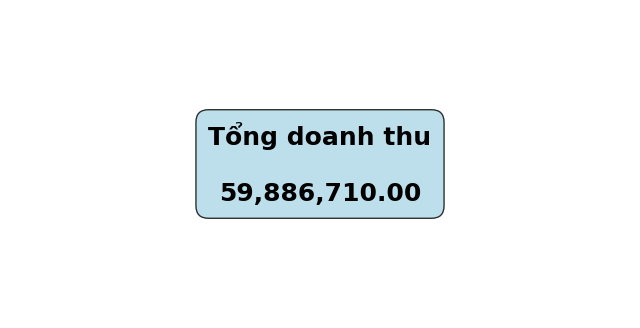

In [44]:
# Tổng lợi nhuận cho đến thời điểm hiện tại
total_revenue = df["Revenue"].sum()
card_plot("Tổng doanh thu", f'{total_revenue:,.2f}')

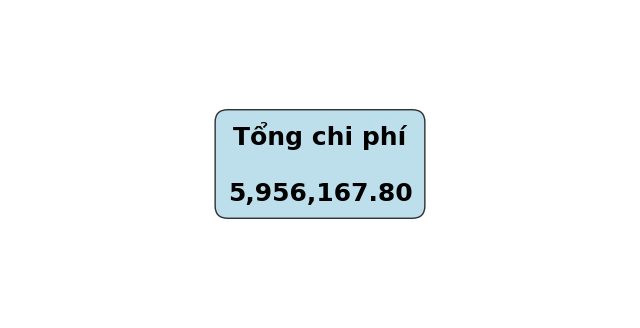

In [45]:
# Tổng lợi nhuận cho đến thời điểm hiện tại
total_spend = df["Spend"].sum()
card_plot("Tổng chi phí", f'{total_spend:,.2f}')

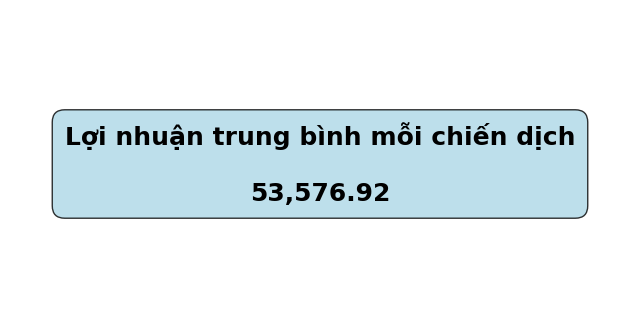

In [46]:
# Trung bình lợi nhuận thu được cho mỗi chiến dịch
avg_profit_per_campaign = df.groupby("Campaign_ID")["Profit"].mean().mean()
card_plot("Lợi nhuận trung bình mỗi chiến dịch", f'{avg_profit_per_campaign:,.2f}')

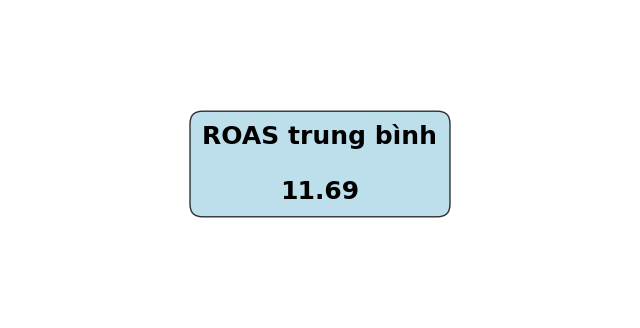

In [47]:
# ROI trung bình của toàn bộ hoạt động marketing
avg_roas = df["ROAS"].mean()
card_plot("ROAS trung bình", f'{avg_roas:.2f}')

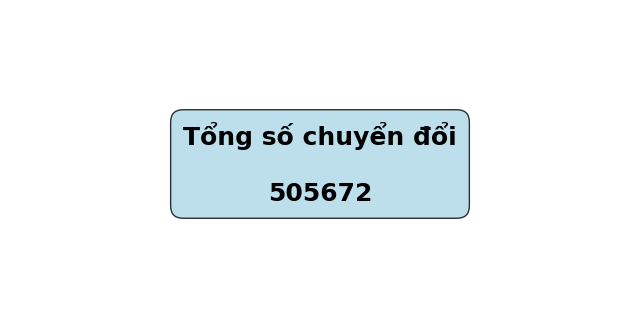

In [50]:
total_conversions = df["Conversions"].sum()
card_plot("Tổng số chuyển đổi", f'{total_conversions}')

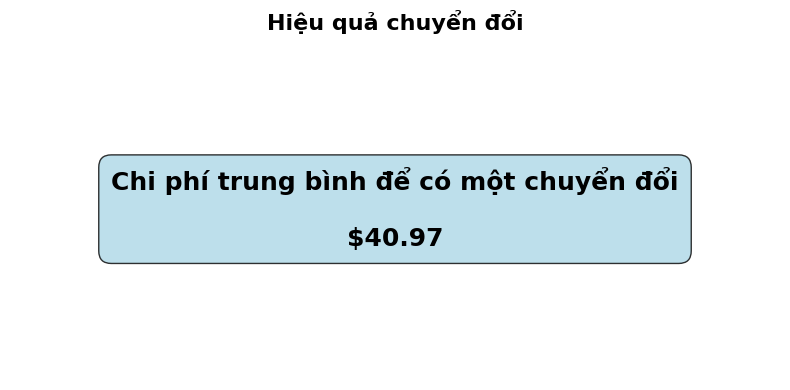

In [29]:
mean_CPA = df["CPA"].mean()

fig, ax = plt.subplots(figsize=(8, 4))
ax.text(0.5, 0.5, f'Chi phí trung bình để có một chuyển đổi\n\n${mean_CPA:.2F}', 
    fontsize=18, fontweight='bold', ha='center', va='center',
    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
plt.title('Hiệu quả chuyển đổi', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

2. Các biểu đồ liên quan đến xu hướng thời gian

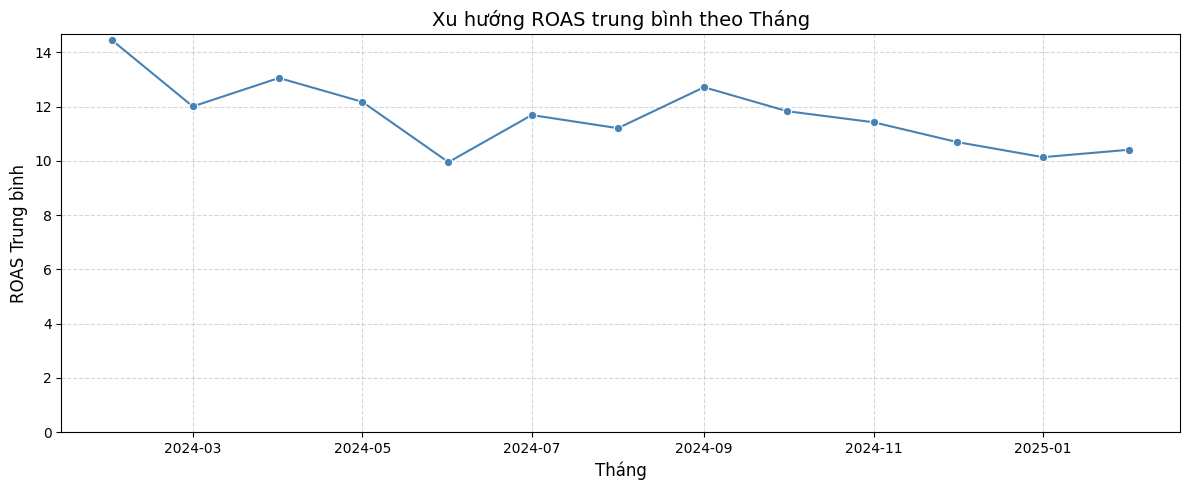

In [ ]:
monthly_roas = df.groupby(df['Date'].dt.to_period('M'))['ROAS'].mean().reset_index()
monthly_roas['Date'] = monthly_roas['Date'].dt.to_timestamp()

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_roas, x="Date", y="ROAS", marker='o', color='steelblue')
plt.title("Xu hướng ROAS trung bình theo Tháng", fontsize=14)
plt.xlabel("Tháng", fontsize=12)
plt.ylabel("ROAS Trung bình", fontsize=12)
plt.ylim(0, None) # Tôi bắt buộc phải thêm cái này để tránh đánh lừa thị giác
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [73]:
# Như chúng ta thấy, ROAS trung bình theo thời gian có xu hướng giảm dần. 
# Thế nhưng nếu ta để ý kĩ thì thực ra dữ liệu này chỉ được thu thập trong khoảng thời gian 1 năm
print("Thời gian min:",df["Date"].dt.date.min(),"Thời gian max:", df["Date"].dt.date.max())

Thời gian min: 2024-02-10 Thời gian max: 2025-02-09


Vậy nên ta chưa thể kết luận rằng ROAS thực sự đang giảm dần vì có thể rằng năm sau nó sẽ lại tăng lên (Do ta thấy trong hình từ 01-2025 trở đi ROAS có vẻ tăng)  
Ở thời điểm hiện tại tôi chỉ có thể kết luận rằng ROAS trung bình trong nằm có xu hướng giảm mạnh vào cuối năm

Tôi đặt ra giả thuyết rằng có vẻ như là vào đợt cuối năm công ty dường như ít triển khai chiến dịch đi ?

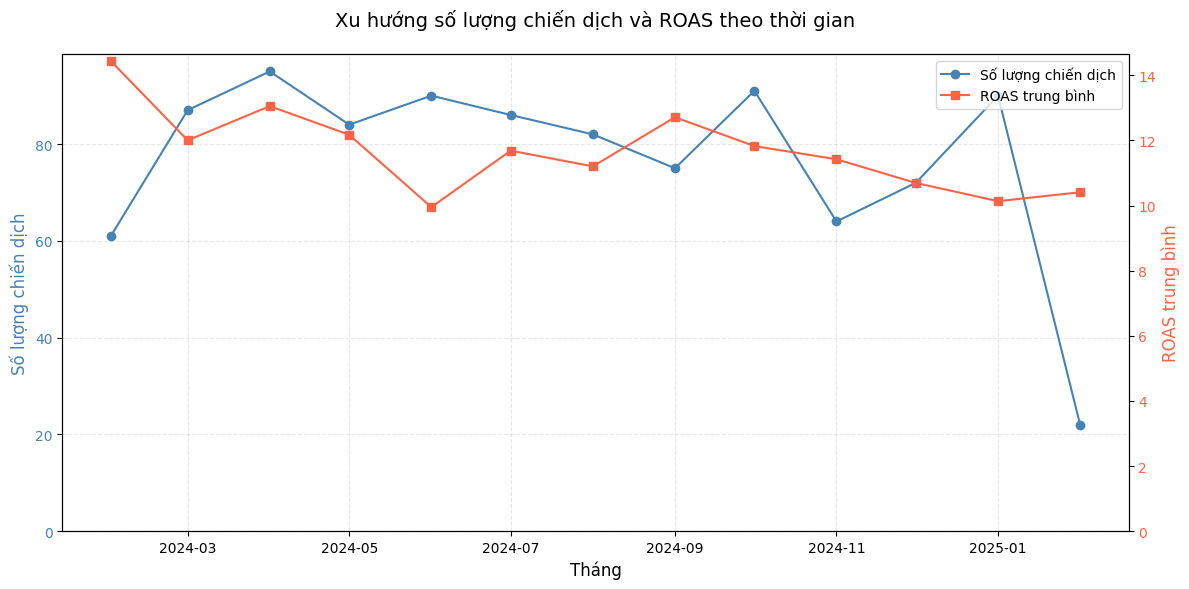

In [87]:
fig, ax1 = plt.subplots(figsize=(12, 6))
monthly_campaigns = df.groupby(df['Date'].dt.to_period('M'))['Campaign_ID'].nunique().reset_index()
monthly_campaigns['Date'] = monthly_campaigns['Date'].dt.to_timestamp()

color1 = 'steelblue'
ax1.set_xlabel('Tháng', fontsize=12)
ax1.set_ylabel('Số lượng chiến dịch', color=color1, fontsize=12)
line1 = ax1.plot(monthly_campaigns['Date'], monthly_campaigns['Campaign_ID'], 
                 marker='o', color=color1, label='Số lượng chiến dịch')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle='--', alpha=0.3)
plt.ylim(0, None)  # Bắt đầu trục Y từ 0 để tránh đánh lừa thị giác
ax2 = ax1.twinx()
color2 = 'tomato'
ax2.set_ylabel('ROAS trung bình', color=color2, fontsize=12)
line2 = ax2.plot(monthly_roas['Date'], monthly_roas['ROAS'], 
                 marker='s', color=color2, label='ROAS trung bình')
ax2.tick_params(axis='y', labelcolor=color2)

# Thêm tiêu đề và legend
plt.title('Xu hướng số lượng chiến dịch và ROAS theo thời gian', fontsize=14, pad=20)

# Tạo legend chung cho cả 2 đường
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
plt.ylim(0, None)
plt.tight_layout()
plt.show()

-> Không, số lượng chiến chiến dịch vào tháng 10 và tháng 1 thậm chí tăng mạnh. Thế nhưng ROAS vẫn giảm

Liệu có phải do là các chiến dịch này có budget rất hạn chế ?

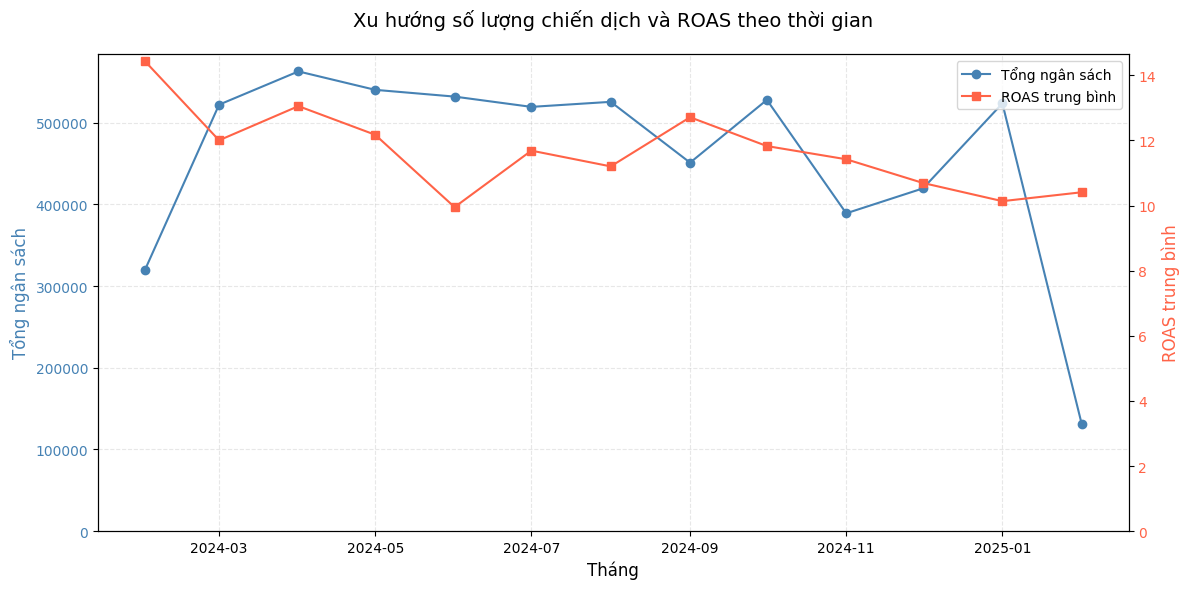

In [91]:
fig, ax1 = plt.subplots(figsize=(12, 6))
monthly_campaigns = df.groupby(df['Date'].dt.to_period('M'))['Budget'].sum().reset_index()
monthly_campaigns['Date'] = monthly_campaigns['Date'].dt.to_timestamp()

color1 = 'steelblue'
ax1.set_xlabel('Tháng', fontsize=12)
ax1.set_ylabel('Tổng ngân sách', color=color1, fontsize=12)
line1 = ax1.plot(monthly_campaigns['Date'], monthly_campaigns['Budget'], 
                 marker='o', color=color1, label='Tổng ngân sách')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle='--', alpha=0.3)
plt.ylim(0, None)  # Bắt đầu trục Y từ 0 để tránh đánh lừa thị giác
ax2 = ax1.twinx()
color2 = 'tomato'
ax2.set_ylabel('ROAS trung bình', color=color2, fontsize=12)
line2 = ax2.plot(monthly_roas['Date'], monthly_roas['ROAS'], 
                 marker='s', color=color2, label='ROAS trung bình')
ax2.tick_params(axis='y', labelcolor=color2)

# Thêm tiêu đề và legend
plt.title('Xu hướng số lượng chiến dịch và ROAS theo thời gian', fontsize=14, pad=20)

# Tạo legend chung cho cả 2 đường
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
plt.ylim(0, None)
plt.tight_layout()
plt.show()

-> Ta thấy rằng ở từ 06 -> 09-2024. Sau khoảng thời gian trước đó đi xuống, ROI có xu hướng tăng lên. Để tâm thấy ở